# 数据读取

In [68]:
import numpy as np
import pandas as pd
import tqdm
tmp=pd.read_parquet('fund_info.parquet')
display(tmp[:5])

,基金代码,基金简称,日期,单位净值,累计净值,日增长率,近1周,近1月,近3月,成立来,...,rates,values,all_values,dates_lenth,profit_std,beta,r_mean,treynor,sharpe,jense
0,009234,鹏华优质企业混合,2022-09-23,1.1620,1.1620,0.01,-2.61,-0.36,-7.62,16.20,...,"1.48,1.07,-0.7,1.91,-0.33,-0.15,-0.43,-1.44,-0...","1.2919,1.3057,1.2966,1.3214,1.3171,1.3151,1.30...","1.2919,1.3057,1.2966,1.3214,1.3171,1.3151,1.30...",703,1.012102147431739,0.571830455933637,-0.13734375000000001,-0.27187910050394853,-0.1536097422523111,-0.05003750968723568
1,100053,富国上证指数ETF联接A,2022-09-23,1.4540,1.4540,-0.41,-0.95,-5.40,-5.65,45.40,...,"0.84,0.89,-1.27,1.09,-0.25,0.38,0.06,-1.46,0.3...","1.565,1.579,1.559,1.576,1.572,1.578,1.579,1.55...","1.565,1.579,1.559,1.576,1.572,1.578,1.579,1.55...",703,0.7834403669672312,1.0041031289989342,-0.09843750000000001,-0.11608618341445656,-0.14878286199525823,0.06856901440917848
2,070009,嘉实超短债债券C,2022-09-23,1.0507,1.5528,0,0.01,0.10,0.70,71.32,...,"0.01,-0.01,0.01,0.01,0.02,0.01,0.0,0.0,0.01,0....","1.0509,1.0508,1.0509,1.051,1.0512,1.0513,1.051...","1.5457,1.5456,1.5457,1.5458,1.546,1.5461,1.546...",703,0.014630874888399531,-4.730853898737107,0.01125,0.0014532260237068982,-0.4698967117442187,-0.8791261875796541
3,012623,金鹰添盈纯债债券C,2022-09-23,0.9174,0.9174,0,0.02,0.10,0.59,-10.97,...,"0.0,0.0,0.01,0.01,0.01,0.0,0.0,0.0,0.01,0.01,0...","0.912,0.912,0.9121,0.9122,0.9123,0.9123,0.9123...","0.912,0.912,0.9121,0.9122,0.9123,0.9123,0.9123...",703,0.028804296554507284,-0.04782829641586712,0.00875,0.1960136718749997,-0.3254722774520597,-0.0181933421516755
4,165311,建信信用增强债券(LOF)A,2022-09-23,1.5430,1.6940,-0.06,0.06,0.13,1.11,77.93,...,"0.07,0.07,-0.07,0.0,0.07,0.0,0.0,0.0,0.0,0.0,-...","1.528,1.529,1.528,1.528,1.529,1.529,1.529,1.52...","1.679,1.68,1.679,1.679,1.68,1.68,1.68,1.68,1.6...",703,0.05381899641390575,3.9070352888289497,0.016875,-0.00031993568206921977,-0.02322599980101127,0.7191096313778377


# 数据处理，划分数据集

In [69]:
row_data=pd.DataFrame(tmp[['基金类型','近1周','近1月','rates','values','all_values']])
tmp_list=['混合型-偏股', '指数型-股票', '债券型-中短债', '债券型-长债', '债券型-混合债', '混合型-灵活','混合型-偏债', '股票型', '债券型-可转债', '混合型-平衡', '商品（不含QDII）', '混合-绝对收益']
row_data['基金类型']=row_data['基金类型'].apply(lambda x:tmp_list.index(x))
week_data=pd.DataFrame(row_data[['基金类型','近1周','rates','values','all_values']])
month_data=pd.DataFrame(row_data[['基金类型','近1月','rates','values','all_values']])
print('cut values length')
for i in tqdm.tqdm(['rates','values','all_values']):
    week_data[i]=week_data[i].apply(lambda x:','.join(x.split(',')[:-5]))
    month_data[i]=month_data[i].apply(lambda x:','.join(x.split(',')[:-22]))

train_week_data = week_data.sample(frac=0.8,random_state=0,axis=0)
test_week_data = week_data[~week_data.index.isin(train_week_data.index)]

train_month_data = month_data.sample(frac=0.8,random_state=0,axis=0)
test_month_data = month_data[~month_data.index.isin(train_month_data.index)]

cut values length


100%|██████████| 3/3 [00:00<00:00, 85.71it/s]


# 训练模型

In [73]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

def get_flatten_features_targets(data,task='近1周'):
    data=pd.DataFrame(data)
    data['features']=data['基金类型'].astype('str')+','+data['rates']+','+data['values']+','+data['all_values']
    features=[[float(j) for j in i.split(',')]for i in data['features'].values]
    targets=[float(i) for i in data[task].values]
    return np.array(features),np.array(targets)

def get_rmse(targets,prds):
    rs=mean_squared_error(targets,prds)
    return np.sqrt(rs)

def train_model(features_tr,targets_tr,features_te,targets_te):

    rs_list=[]
    model_list=[]

    model=XGBRegressor(random_state=0,n_jobs=8,n_estimators=2000)
    model.fit(features_tr,targets_tr,early_stopping_rounds = 100,eval_set=[(features_te,targets_te)],verbose=False)
    prd=model.predict(features_te)
    rs=get_rmse(targets_te,prd)
    rs_list.append(rs)
    model_list.append(model)
    print('XGBRegressor',rs)

    model=SVR(max_iter=-1,verbose=False,cache_size=10000)
    model.fit(features_tr,targets_tr)
    prd=model.predict(features_te)
    rs=get_rmse(targets_te,prd)
    rs_list.append(rs)
    model_list.append(model)
    print('SVR',rs)

    model=LinearRegression()
    model.fit(features_tr,targets_tr)
    prd=model.predict(features_te)
    rs=get_rmse(targets_te,prd)
    rs_list.append(rs)
    model_list.append(model)
    print('LinearRegression',rs)

    model=RandomForestRegressor(n_jobs=8)
    model.fit(features_tr,targets_tr)
    prd=model.predict(features_te)
    rs=get_rmse(targets_te,prd)
    rs_list.append(rs)
    model_list.append(model)
    print('RandomForestRegressor',rs)

    return model_list,rs_list

features_tr,targets_tr=get_flatten_features_targets(train_week_data)
features_te,targets_te=get_flatten_features_targets(test_week_data)
std_scaler=StandardScaler()
features_tr=std_scaler.fit_transform(features_tr)
features_te=std_scaler.transform(features_te)
models1,rsts1=train_model(features_tr,targets_tr,features_te,targets_te)

features_tr,targets_tr=get_flatten_features_targets(train_month_data,'近1月')
features_te,targets_te=get_flatten_features_targets(test_month_data,'近1月')
std_scaler=StandardScaler()
features_tr=std_scaler.fit_transform(features_tr)
features_te=std_scaler.transform(features_te)
models2,rsts2=train_model(features_tr,targets_tr,features_te,targets_te)

XGBRegressor 0.5361574965167498
SVR 0.5825325368941583
LinearRegression 0.7971749001135644
RandomForestRegressor 0.5130906460185627
XGBRegressor 1.4416585123545547
SVR 1.678649330643219
LinearRegression 4.545965295797594
RandomForestRegressor 1.298539832356686


Text(0.5, 1.0, 'Model Comparison (rmse)')

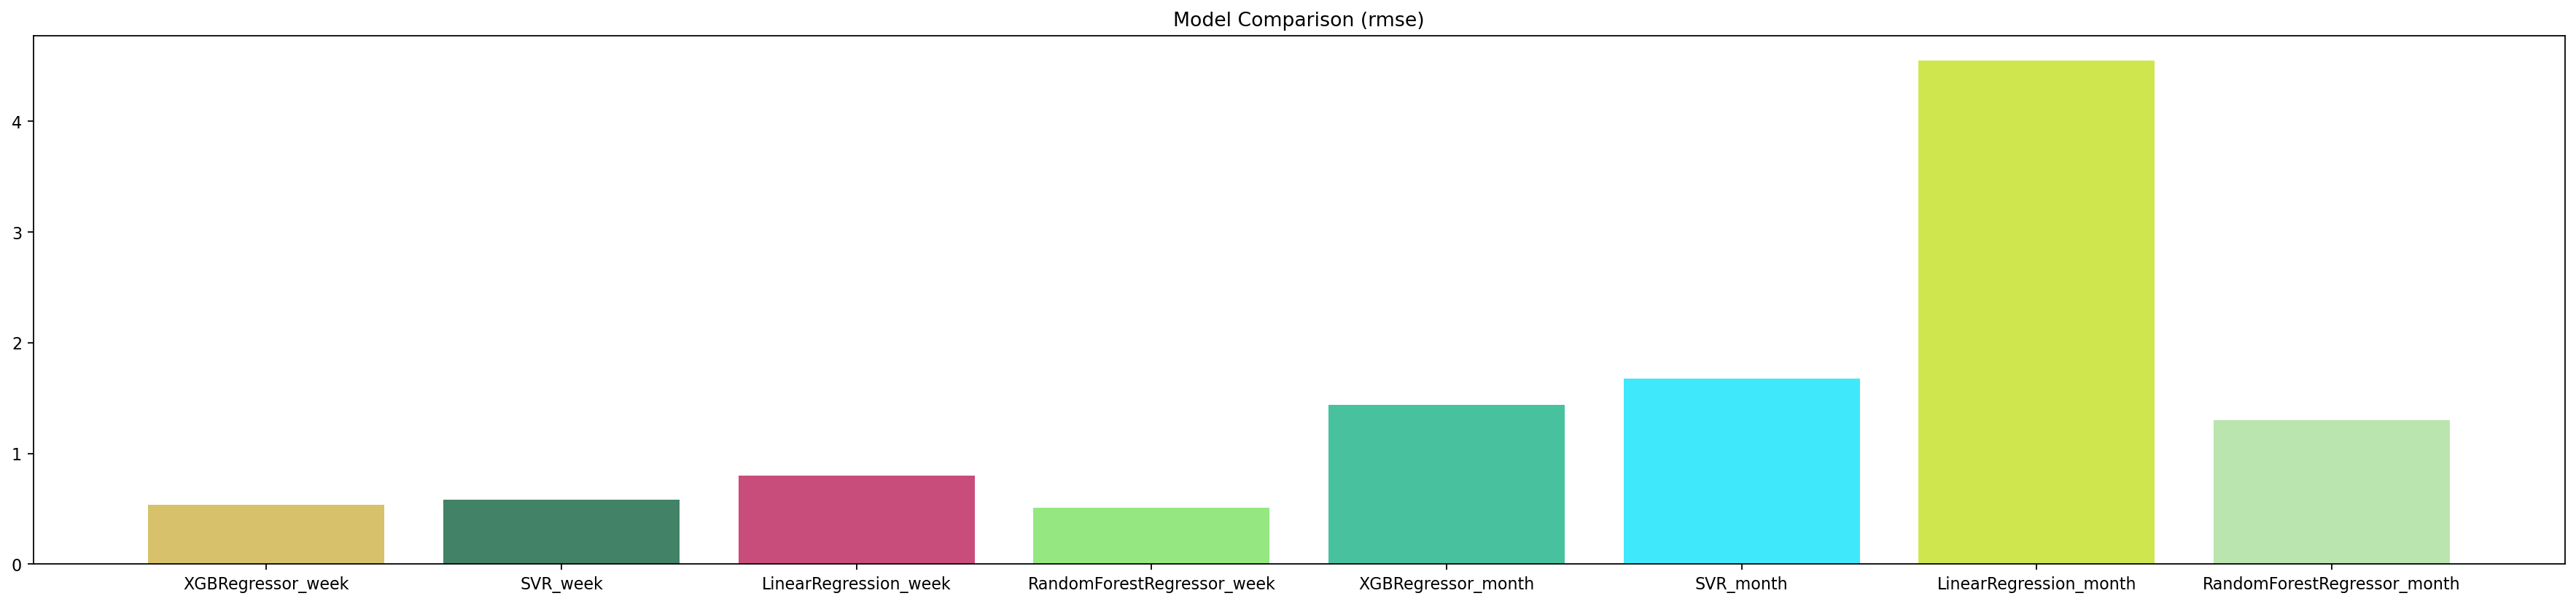

In [74]:
from turtle import title
import matplotlib.pyplot as plt
import random
random.seed(0)
y_data =rsts1+rsts2
x_data =['XGBRegressor_week','SVR_week','LinearRegression_week','RandomForestRegressor_week','XGBRegressor_month','SVR_month','LinearRegression_month','RandomForestRegressor_month']
colors = [(random.random(),random.random(),random.random()) for i in range(8)]

plt.figure(figsize=(28,6),dpi=160)
plt.bar(x_data,y_data,color=colors)
plt.title("Model Comparison (rmse)")

In [81]:
week_data=pd.DataFrame(row_data[['基金类型','近1周','rates','values','all_values']])
month_data=pd.DataFrame(row_data[['基金类型','近1月','rates','values','all_values']])
print('cut values length')
for i in tqdm.tqdm(['rates','values','all_values']):
    week_data[i]=week_data[i].apply(lambda x:','.join(x.split(',')[5:]))
    month_data[i]=month_data[i].apply(lambda x:','.join(x.split(',')[22:]))

features_tr,targets_tr=get_flatten_features_targets(week_data)
prds=models1[0].predict(features_tr)
tmp['未来1周']=prds
tmp['未来1周']=tmp['未来1周'].astype('str')

features_tr,targets_tr=get_flatten_features_targets(month_data,'近1月')
prds=models2[0].predict(features_tr)
tmp['未来1月']=prds
tmp['未来1月']=tmp['未来1月'].astype('str')

tmp.to_parquet('fund_pred.parquet')

cut values length


100%|██████████| 3/3 [00:00<00:00, 88.23it/s]
